In [1]:
!pip install accelerate

     |████████████████████████████████| 58 kB 2.7 MB/s 


In [2]:
import sys
sys.path.append("../input/timmmaster/")

In [3]:
import os
import gc
import cv2
import sys
import math
import time
import timm
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from accelerate import Accelerator

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2

from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
y_ = Fore.YELLOW
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

In [4]:
config = {'lr':5e-5,
          'wd':1e-2,
          'bs':64,
          'img_size':256,
          'nfolds':5,
          'epochs':20,
          'num_workers':4,
          'seed':1000,
          'model_name':'tf_efficientnet_b0',
         }

os.makedirs(f'models',exist_ok=True)
os.makedirs(f'plots',exist_ok=True)
    
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])


def get_train_transforms():
    return A.Compose(
        [
            A.Resize(config['img_size'],config['img_size'],always_apply=True),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=180, p=0.7),
            A.ShiftScaleRotate(
                shift_limit = 0.1, scale_limit=0.1, rotate_limit=45, p=0.5
            ),
            A.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.2,
                val_shift_limit=0.2, p=0.5
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1),
                contrast_limit=(-0.1, 0.1), p=0.5
            ),
            ToTensorV2(p=1.0),
        ]
    )

classes = ['AnnualCrop', 'HerbaceousVegetation', 'PermanentCrop',
       'Industrial', 'Pasture', 'Highway', 'Residential', 'River',
       'SeaLake', 'Forest']

num_classes = len(classes)

class_to_label = {value:key for key,value in enumerate(classes)}
label_to_class = {key:value for key,value in enumerate(classes)}

image_path = '../input/eurosat-dataset/EuroSAT/'
train_data = pd.read_csv("../input/eurosat-dataset/EuroSAT/train.csv")
test_data = pd.read_csv("../input/eurosat-dataset/EuroSAT/test.csv")

train_data['label'] = train_data['ClassName'].map(class_to_label)
test_data['label'] = test_data['ClassName'].map(class_to_label)

train_data['path'] = image_path + train_data['Filename']
test_data['path'] = image_path + test_data['Filename']

train_data['Fold'] = -1
kfold = StratifiedKFold(n_splits=config['nfolds'],shuffle=True,random_state=config['seed'])
for k , (train_idx,valid_idx) in enumerate(kfold.split(X=train_data,y=train_data['ClassName'])):
    train_data.loc[valid_idx,'Fold'] = k

In [5]:
train_data.head()

,Unnamed: 0,Filename,Label,ClassName,label,path,Fold
0,16257,AnnualCrop/AnnualCrop_142.jpg,0,AnnualCrop,0,../input/eurosat-dataset/EuroSAT/AnnualCrop/An...,1
1,3297,HerbaceousVegetation/HerbaceousVegetation_2835...,2,HerbaceousVegetation,1,../input/eurosat-dataset/EuroSAT/HerbaceousVeg...,0
2,17881,PermanentCrop/PermanentCrop_1073.jpg,6,PermanentCrop,2,../input/eurosat-dataset/EuroSAT/PermanentCrop...,1
3,2223,Industrial/Industrial_453.jpg,4,Industrial,3,../input/eurosat-dataset/EuroSAT/Industrial/In...,1
4,4887,HerbaceousVegetation/HerbaceousVegetation_1810...,2,HerbaceousVegetation,1,../input/eurosat-dataset/EuroSAT/HerbaceousVeg...,2


In [6]:
def plot_loss_score(fold,train_losses,valid_losses,scores):
    print("Best Train Loss",np.min(train_losses))
    print("Best Valid Loss",np.min(valid_losses))
    print("Best Accuracy Score",np.max(scores))

    plt.figure(figsize=(15,7))
    plt.subplot(121)
    sns.lineplot(x=list(range(len(train_losses))),y=train_losses,label='train loss')
    sns.lineplot(x=list(range(len(valid_losses))),y=valid_losses,label='valid_loss');
    plt.xlabel("Epochs");
    plt.ylabel("Cross entropy loss");
    plt.title("Graph of epoch vs loss")
    plt.legend()

    plt.subplot(122)
    sns.lineplot(x=list(range(len(scores))),y=scores,label='score')
    plt.xlabel("Epochs");
    plt.ylabel("Accuracy");
    plt.title("Graph of epoch vs score")
    plt.legend()

    plt.savefig(f"plots/loss_score_plot{fold}.png")

    plt.show()

In [7]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [8]:
class EuroSatDataset(Dataset):
    def __init__(self,df,transforms=None):
        self.df = df
        self.transforms = transforms
    
    def __getitem__(self,idx):
        path = self.df.loc[idx,"path"]
        label = self.df.loc[idx,"label"]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']
        
        label = torch.tensor(label,dtype=torch.long)
        image = torch.tensor(image,dtype=torch.float)
        
        return image,label
    
    def __len__(self):
        return len(self.df)

In [9]:
class Model(nn.Module):
    def __init__(self,model_path,pretrained=True):
        super(Model,self).__init__()
        self.backbone = timm.create_model(model_path,pretrained=pretrained)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(in_features,128)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.layer = nn.Linear(128,num_classes)
    
    def forward(self,x):
        x = self.relu(self.backbone(x))
        x = self.layer(self.dropout(x))
        return x

In [10]:
def run(fold,patience=3,plot=True):
    loss_fn = nn.CrossEntropyLoss()
    
    def evaluate(model,valid_loader):
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            all_outputs = list()
            all_targets = list()
            for i, (inputs,targets) in enumerate(tqdm(valid_loader)):
                outputs = model(inputs)
                loss = loss_fn(outputs,targets)
                valid_loss += loss.item()
                outputs = (outputs.detach().cpu().numpy().argmax(axis=1))
                all_outputs.extend(outputs.tolist())
                all_targets.extend(targets.detach().cpu().numpy().tolist())

        score = accuracy_score(all_targets,all_outputs)

        valid_loss /= len(valid_loader)
        return valid_loss,score
        
    def train_and_evaluate_loop(train_loader,valid_loader,model,optimizer,
                                epoch,fold,best_loss,best_score,lr_scheduler=None):
        train_loss = 0
        for i, (inputs,targets) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            model.train()
            outputs = model(inputs)
            loss = loss_fn(outputs,targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if lr_scheduler:
                lr_scheduler.step()
        
        train_loss /= len(train_loader)
        valid_loss,score = evaluate(model,valid_loader) 

        if score > best_score:
            best_score = score
        
        print(f"Epoch:{epoch} |Train Loss:{train_loss}|Valid Loss:{valid_loss}| Score: {score}")

        if valid_loss <= best_loss:
            print(f"{g_}Loss Decreased from {best_loss} to {valid_loss}{sr_}")
            best_loss = valid_loss
            torch.save(model.state_dict(),f'./models/model{fold}.bin')
                    
        return best_loss,best_score,train_loss,valid_loss,score
        
    accelerator = Accelerator()
    print(f"{accelerator.device} is used")
    
    early_stopping = EarlyStopping(patience)
    
#     td = train_data.sample(n=100).reset_index(drop=True)
    x_train = train_data.query(f"Fold != {fold}").reset_index(drop=True)
    x_valid = train_data.query(f"Fold == {fold}").reset_index(drop=True)
    
    model = Model(config['model_name'])
    
    train_ds = EuroSatDataset(x_train,transforms=get_train_transforms())
    train_dl = DataLoader(train_ds,
                        batch_size = config["bs"],
                        num_workers = config['num_workers'],
                        shuffle=True,
                        pin_memory=True,
                        drop_last=True)
    
    valid_ds = EuroSatDataset(x_valid,transforms=get_train_transforms())
    valid_dl = DataLoader(valid_ds,
                        batch_size = config["bs"],
                        num_workers = config['num_workers'],
                        shuffle=False,
                        pin_memory=True,
                        drop_last=False)
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias"]
    optimizer_parameters = [
        {
            "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.01,
        },
        {
            "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]

    optimizer = optim.AdamW(optimizer_parameters,lr=config['lr'],weight_decay=config['wd'])    
#     lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)
    lr_scheduler = None
    
    model,train_dl,valid_dl,optimizer,lr_scheduler = accelerator.prepare(model,train_dl,valid_dl,optimizer,lr_scheduler)

    best_loss = 9999
    best_score=0
    start_time = time.time()
    train_loss_per_epoch = list()
    valid_loss_per_epoch = list()
    score_per_epochs = list()
    for epoch in range(config["epochs"]):
        print(f"Epoch Started:{epoch}")
        best_loss,best_score,train_loss,valid_loss,score = train_and_evaluate_loop(train_dl,valid_dl,model,
                                                                                   optimizer,epoch,fold,best_loss,
                                                                                   best_score,lr_scheduler)  
        train_loss_per_epoch.append(train_loss)
        valid_loss_per_epoch.append(valid_loss)
        score_per_epochs.append(score)

        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
              
        end_time = time.time()
        print(f"Time taken by epoch {epoch} is {end_time-start_time:.2f}s")
        start_time = end_time

    if plot:
        plot_loss_score(fold,train_loss_per_epoch,valid_loss_per_epoch,score_per_epochs) 

cuda is used


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


Epoch Started:0


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:0 |Train Loss:1.4652334630994472|Valid Loss:0.7832763940095901| Score: 0.7505291005291005
Loss Decreased from 9999 to 0.7832763940095901
Time taken by epoch 0 is 123.52s
Epoch Started:1


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:1 |Train Loss:0.6880763654234046|Valid Loss:0.518009748061498| Score: 0.8097883597883598
Loss Decreased from 0.7832763940095901 to 0.518009748061498
Time taken by epoch 1 is 103.25s
Epoch Started:2


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:2 |Train Loss:0.5524474801653523|Valid Loss:0.4744676031172276| Score: 0.816931216931217
Loss Decreased from 0.518009748061498 to 0.4744676031172276
Time taken by epoch 2 is 102.77s
Epoch Started:3


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:3 |Train Loss:0.5199991627517393|Valid Loss:0.4311452699204286| Score: 0.8333333333333334
Loss Decreased from 0.4744676031172276 to 0.4311452699204286
Time taken by epoch 3 is 103.30s
Epoch Started:4


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:4 |Train Loss:0.4889425953566018|Valid Loss:0.4283099927008152| Score: 0.8298941798941799
Loss Decreased from 0.4311452699204286 to 0.4283099927008152
Time taken by epoch 4 is 105.46s
Epoch Started:5


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:5 |Train Loss:0.45472923615726374|Valid Loss:0.41334999998410543| Score: 0.8423280423280424
Loss Decreased from 0.4283099927008152 to 0.41334999998410543
Time taken by epoch 5 is 103.55s
Epoch Started:6


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:6 |Train Loss:0.4518681670523296|Valid Loss:0.4054433727016052| Score: 0.8396825396825397
Loss Decreased from 0.41334999998410543 to 0.4054433727016052
Time taken by epoch 6 is 102.55s
Epoch Started:7


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:7 |Train Loss:0.43835245925238575|Valid Loss:0.3910914473235607| Score: 0.8481481481481481
Loss Decreased from 0.4054433727016052 to 0.3910914473235607
Time taken by epoch 7 is 104.09s
Epoch Started:8


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:8 |Train Loss:0.4279553133804919|Valid Loss:0.3864990783234437| Score: 0.8404761904761905
Loss Decreased from 0.3910914473235607 to 0.3864990783234437
Time taken by epoch 8 is 104.26s
Epoch Started:9


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:9 |Train Loss:0.41296115378707143|Valid Loss:0.37105129417032| Score: 0.8558201058201058
Loss Decreased from 0.3864990783234437 to 0.37105129417032
Time taken by epoch 9 is 104.82s
Epoch Started:10


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:10 |Train Loss:0.4119656807032682|Valid Loss:0.3765612925092379| Score: 0.8537037037037037
EarlyStopping counter: 1 out of 3
Time taken by epoch 10 is 104.66s
Epoch Started:11


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:11 |Train Loss:0.3991415136951511|Valid Loss:0.37838391537467636| Score: 0.8510582010582011
EarlyStopping counter: 2 out of 3
Time taken by epoch 11 is 103.58s
Epoch Started:12


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:12 |Train Loss:0.40085245321615265|Valid Loss:0.37971557999650635| Score: 0.8558201058201058
EarlyStopping counter: 3 out of 3
Early stopping
Best Train Loss 0.3991415136951511
Best Valid Loss 0.37105129417032
Best Accuracy Score 0.8558201058201058


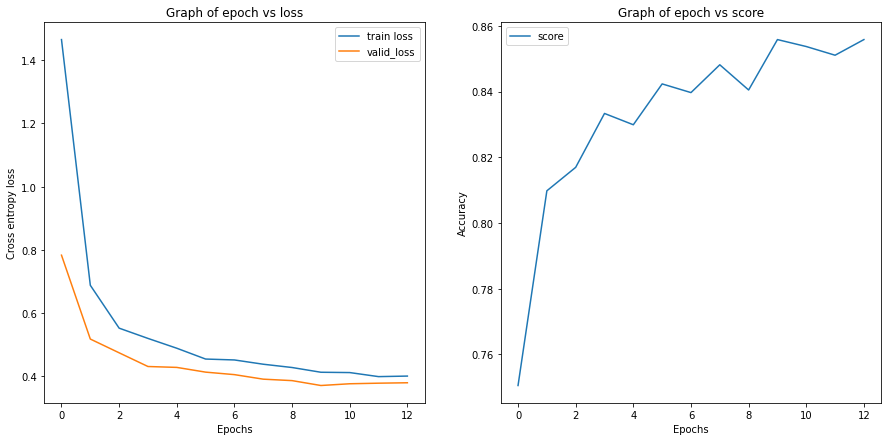

cuda is used
Epoch Started:0


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:0 |Train Loss:1.4632654965428982|Valid Loss:0.7905777633190155| Score: 0.7412698412698413
Loss Decreased from 9999 to 0.7905777633190155
Time taken by epoch 0 is 105.82s
Epoch Started:1


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:1 |Train Loss:0.6791748263068118|Valid Loss:0.5358311424652735| Score: 0.8084656084656084
Loss Decreased from 0.7905777633190155 to 0.5358311424652735
Time taken by epoch 1 is 105.33s
Epoch Started:2


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:2 |Train Loss:0.5586315826591799|Valid Loss:0.47273372958103815| Score: 0.8195767195767196
Loss Decreased from 0.5358311424652735 to 0.47273372958103815
Time taken by epoch 2 is 104.60s
Epoch Started:3


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:3 |Train Loss:0.5050613992547585|Valid Loss:0.4573645087579886| Score: 0.8238095238095238
Loss Decreased from 0.47273372958103815 to 0.4573645087579886
Time taken by epoch 3 is 103.29s
Epoch Started:4


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:4 |Train Loss:0.4940886124337124|Valid Loss:0.4410426581899325| Score: 0.8359788359788359
Loss Decreased from 0.4573645087579886 to 0.4410426581899325
Time taken by epoch 4 is 102.23s
Epoch Started:5


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:5 |Train Loss:0.4635912885857841|Valid Loss:0.4307861069838206| Score: 0.8288359788359788
Loss Decreased from 0.4410426581899325 to 0.4307861069838206
Time taken by epoch 5 is 102.56s
Epoch Started:6


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:6 |Train Loss:0.4441396218361491|Valid Loss:0.430784052113692| Score: 0.8402116402116402
Loss Decreased from 0.4307861069838206 to 0.430784052113692
Time taken by epoch 6 is 103.47s
Epoch Started:7


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:7 |Train Loss:0.4407920675131224|Valid Loss:0.3815467415920769| Score: 0.8489417989417989
Loss Decreased from 0.430784052113692 to 0.3815467415920769
Time taken by epoch 7 is 103.26s
Epoch Started:8


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:8 |Train Loss:0.41834291323261746|Valid Loss:0.3733389891684055| Score: 0.8544973544973545
Loss Decreased from 0.3815467415920769 to 0.3733389891684055
Time taken by epoch 8 is 103.93s
Epoch Started:9


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:9 |Train Loss:0.41776405243297754|Valid Loss:0.38363234177231786| Score: 0.8468253968253968
EarlyStopping counter: 1 out of 3
Time taken by epoch 9 is 104.88s
Epoch Started:10


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:10 |Train Loss:0.4062666934046705|Valid Loss:0.3981193052760015| Score: 0.8457671957671957
EarlyStopping counter: 2 out of 3
Time taken by epoch 10 is 103.54s
Epoch Started:11


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:11 |Train Loss:0.3983687202177815|Valid Loss:0.37977788895368575| Score: 0.85
EarlyStopping counter: 3 out of 3
Early stopping
Best Train Loss 0.3983687202177815
Best Valid Loss 0.3733389891684055
Best Accuracy Score 0.8544973544973545


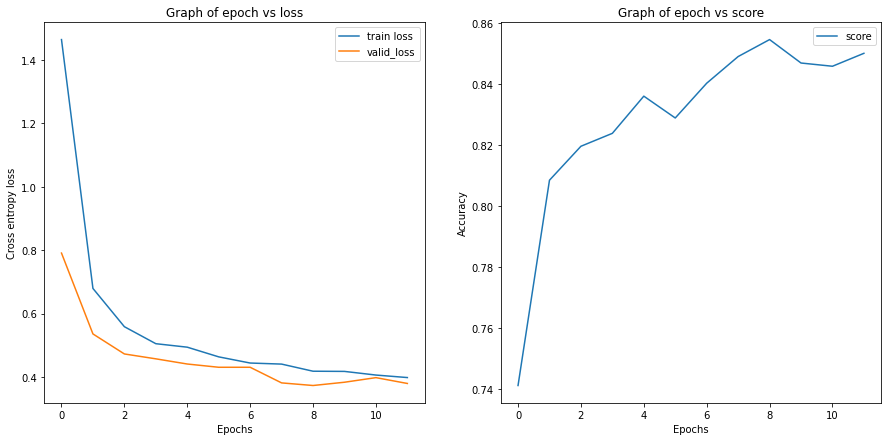

cuda is used
Epoch Started:0


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:0 |Train Loss:1.4795684193150471|Valid Loss:0.7712899724642436| Score: 0.7645502645502645
Loss Decreased from 9999 to 0.7712899724642436
Time taken by epoch 0 is 103.07s
Epoch Started:1


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:1 |Train Loss:0.6684174336871859|Valid Loss:0.5247946143150329| Score: 0.8126984126984127
Loss Decreased from 0.7712899724642436 to 0.5247946143150329
Time taken by epoch 1 is 104.63s
Epoch Started:2


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:2 |Train Loss:0.5493359472286903|Valid Loss:0.4753299077351888| Score: 0.8166666666666667
Loss Decreased from 0.5247946143150329 to 0.4753299077351888
Time taken by epoch 2 is 104.41s
Epoch Started:3


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:3 |Train Loss:0.5141969859852629|Valid Loss:0.4567930489778519| Score: 0.823015873015873
Loss Decreased from 0.4753299077351888 to 0.4567930489778519
Time taken by epoch 3 is 103.78s
Epoch Started:4


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:4 |Train Loss:0.48083942017312775|Valid Loss:0.43254396269718803| Score: 0.8359788359788359
Loss Decreased from 0.4567930489778519 to 0.43254396269718803
Time taken by epoch 4 is 103.20s
Epoch Started:5


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:5 |Train Loss:0.472851581682088|Valid Loss:0.4514331132173538| Score: 0.8296296296296296
EarlyStopping counter: 1 out of 3
Time taken by epoch 5 is 104.58s
Epoch Started:6


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:6 |Train Loss:0.4460831909614094|Valid Loss:0.42340494990348815| Score: 0.8317460317460318
Loss Decreased from 0.43254396269718803 to 0.42340494990348815
Time taken by epoch 6 is 104.05s
Epoch Started:7


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:7 |Train Loss:0.4399559045747175|Valid Loss:0.4099129892885685| Score: 0.8362433862433862
Loss Decreased from 0.42340494990348815 to 0.4099129892885685
Time taken by epoch 7 is 103.12s
Epoch Started:8


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:8 |Train Loss:0.4205773375549559|Valid Loss:0.4383329232533773| Score: 0.8351851851851851
EarlyStopping counter: 1 out of 3
Time taken by epoch 8 is 106.86s
Epoch Started:9


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:9 |Train Loss:0.4181639543276722|Valid Loss:0.3965717896819115| Score: 0.8283068783068783
Loss Decreased from 0.4099129892885685 to 0.3965717896819115
Time taken by epoch 9 is 103.00s
Epoch Started:10


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:10 |Train Loss:0.40707283927980115|Valid Loss:0.39360556192696095| Score: 0.8462962962962963
Loss Decreased from 0.3965717896819115 to 0.39360556192696095
Time taken by epoch 10 is 102.49s
Epoch Started:11


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:11 |Train Loss:0.40182544436242623|Valid Loss:0.3714763524631659| Score: 0.8481481481481481
Loss Decreased from 0.39360556192696095 to 0.3714763524631659
Time taken by epoch 11 is 103.61s
Epoch Started:12


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:12 |Train Loss:0.397753110376455|Valid Loss:0.3999505043029785| Score: 0.8476190476190476
EarlyStopping counter: 1 out of 3
Time taken by epoch 12 is 101.69s
Epoch Started:13


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:13 |Train Loss:0.3861126599801799|Valid Loss:0.3911276166637739| Score: 0.8484126984126984
EarlyStopping counter: 2 out of 3
Time taken by epoch 13 is 101.17s
Epoch Started:14


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:14 |Train Loss:0.3924790945346073|Valid Loss:0.3927255019545555| Score: 0.8518518518518519
EarlyStopping counter: 3 out of 3
Early stopping
Best Train Loss 0.3861126599801799
Best Valid Loss 0.3714763524631659
Best Accuracy Score 0.8518518518518519


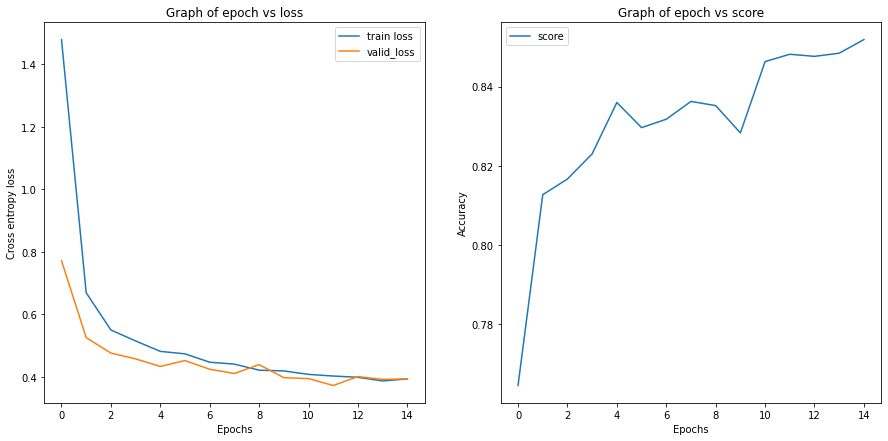

cuda is used
Epoch Started:0


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:0 |Train Loss:1.48126916865171|Valid Loss:0.8052203396956126| Score: 0.7238095238095238
Loss Decreased from 9999 to 0.8052203396956126
Time taken by epoch 0 is 101.19s
Epoch Started:1


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:1 |Train Loss:0.6756525583944079|Valid Loss:0.5340155463044842| Score: 0.8026455026455026
Loss Decreased from 0.8052203396956126 to 0.5340155463044842
Time taken by epoch 1 is 101.00s
Epoch Started:2


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:2 |Train Loss:0.5556905836624614|Valid Loss:0.502765299876531| Score: 0.8134920634920635
Loss Decreased from 0.5340155463044842 to 0.502765299876531
Time taken by epoch 2 is 102.85s
Epoch Started:3


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:3 |Train Loss:0.50977786744045|Valid Loss:0.46743884682655334| Score: 0.8222222222222222
Loss Decreased from 0.502765299876531 to 0.46743884682655334
Time taken by epoch 3 is 101.56s
Epoch Started:4


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:4 |Train Loss:0.4834370436936112|Valid Loss:0.41378858083238207| Score: 0.841005291005291
Loss Decreased from 0.46743884682655334 to 0.41378858083238207
Time taken by epoch 4 is 104.72s
Epoch Started:5


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:5 |Train Loss:0.4575212289721279|Valid Loss:0.42351190523865323| Score: 0.8357142857142857
EarlyStopping counter: 1 out of 3
Time taken by epoch 5 is 104.61s
Epoch Started:6


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:6 |Train Loss:0.43485232871972906|Valid Loss:0.42063613384962084| Score: 0.8455026455026455
EarlyStopping counter: 2 out of 3
Time taken by epoch 6 is 102.97s
Epoch Started:7


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:7 |Train Loss:0.43402280797392634|Valid Loss:0.4229912047584852| Score: 0.83994708994709
EarlyStopping counter: 3 out of 3
Early stopping
Best Train Loss 0.43402280797392634
Best Valid Loss 0.41378858083238207
Best Accuracy Score 0.8455026455026455


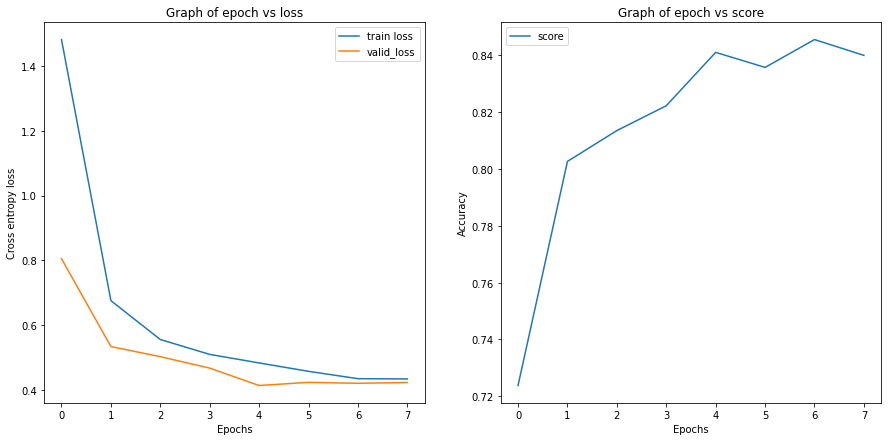

cuda is used
Epoch Started:0


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:0 |Train Loss:1.4818170045391987|Valid Loss:0.8203427602847417| Score: 0.7439153439153439
Loss Decreased from 9999 to 0.8203427602847417
Time taken by epoch 0 is 102.72s
Epoch Started:1


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:1 |Train Loss:0.7008108795951988|Valid Loss:0.5234862804412842| Score: 0.8164021164021164
Loss Decreased from 0.8203427602847417 to 0.5234862804412842
Time taken by epoch 1 is 102.70s
Epoch Started:2


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:2 |Train Loss:0.5623125052553112|Valid Loss:0.47766794115304945| Score: 0.8238095238095238
Loss Decreased from 0.5234862804412842 to 0.47766794115304945
Time taken by epoch 2 is 102.24s
Epoch Started:3


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:3 |Train Loss:0.5206738773543956|Valid Loss:0.461815237502257| Score: 0.8291005291005291
Loss Decreased from 0.47766794115304945 to 0.461815237502257
Time taken by epoch 3 is 104.34s
Epoch Started:4


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:4 |Train Loss:0.5061781046501661|Valid Loss:0.420249122629563| Score: 0.8346560846560847
Loss Decreased from 0.461815237502257 to 0.420249122629563
Time taken by epoch 4 is 102.47s
Epoch Started:5


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:5 |Train Loss:0.4698406620803526|Valid Loss:0.4226057710746924| Score: 0.8407407407407408
EarlyStopping counter: 1 out of 3
Time taken by epoch 5 is 102.60s
Epoch Started:6


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:6 |Train Loss:0.4485591232650361|Valid Loss:0.38989250765492517| Score: 0.83994708994709
Loss Decreased from 0.420249122629563 to 0.38989250765492517
Time taken by epoch 6 is 103.26s
Epoch Started:7


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:7 |Train Loss:0.44566334411501884|Valid Loss:0.39501474623878796| Score: 0.8436507936507937
EarlyStopping counter: 1 out of 3
Time taken by epoch 7 is 100.81s
Epoch Started:8


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:8 |Train Loss:0.4362436264627061|Valid Loss:0.40108357965946195| Score: 0.8402116402116402
EarlyStopping counter: 2 out of 3
Time taken by epoch 8 is 102.42s
Epoch Started:9


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch:9 |Train Loss:0.4289837023716862|Valid Loss:0.4075429290533066| Score: 0.841005291005291
EarlyStopping counter: 3 out of 3
Early stopping
Best Train Loss 0.4289837023716862
Best Valid Loss 0.38989250765492517
Best Accuracy Score 0.8436507936507937


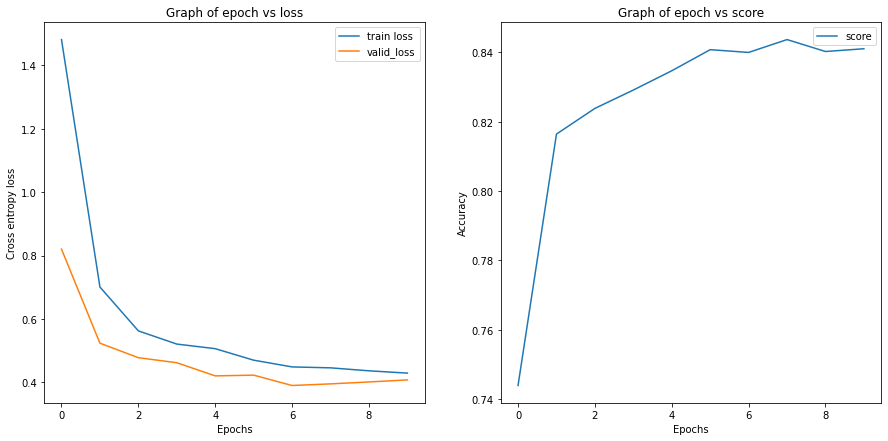

In [11]:
for x in range(config['nfolds']):
    run(x)

## Testing Model

In [12]:
def get_test_transforms():
    return A.Compose(
        [
            A.Resize(config['img_size'],config['img_size'],always_apply=True),
            A.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
           ),
            ToTensorV2(p=1.0)
        ])

In [13]:
class EuroSatDatasetTest(Dataset):
    def __init__(self,df,transforms=None):
        self.df = df
        self.transforms = transforms
    
    def __getitem__(self,idx):
        path = self.df.loc[idx,"path"]
        label = self.df.loc[idx,"label"]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']
        
        label = torch.tensor(label,dtype=torch.long)
        image = torch.tensor(image,dtype=torch.float)
        
        return image
    
    def __len__(self):
        return len(self.df)

In [14]:
def get_prediction(df,model_paths,device='cuda'):
    predictions = list()
    
    for path,model_name in model_paths:
        model = Model(model_name,pretrained=False)

        for f in range(config['nfolds']):
            model.load_state_dict(torch.load(path.format(f),map_location=device))
            model.to(device)
            model.eval()

            test_ds = EuroSatDatasetTest(df,transforms=get_test_transforms())
            test_dl = DataLoader(test_ds,
                                batch_size = config["bs"],
                                num_workers = config['num_workers'],
                                shuffle=False,
                                pin_memory=True,
                                drop_last=False)

            with torch.no_grad():
                prediction = list()
                for i, inputs in enumerate(test_dl):
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    pred = outputs.detach().cpu().numpy().tolist()
                    prediction.extend(pred)
                predictions.append(prediction)

    torch.cuda.empty_cache()
    predictions = np.mean(predictions,axis=0).argmax(axis=1)
    return predictions

In [15]:
model_paths = [
    ('./models/model{0}.bin',config['model_name'])
]

In [16]:
test_data['covertype'] = get_prediction(test_data,model_paths)

In [17]:
test_data.head()

,Unnamed: 0,Filename,Label,ClassName,label,path,covertype
0,2438,AnnualCrop/AnnualCrop_1275.jpg,0,AnnualCrop,0,../input/eurosat-dataset/EuroSAT/AnnualCrop/An...,0
1,1018,Residential/Residential_504.jpg,7,Residential,6,../input/eurosat-dataset/EuroSAT/Residential/R...,6
2,3,Pasture/Pasture_787.jpg,5,Pasture,4,../input/eurosat-dataset/EuroSAT/Pasture/Pastu...,4
3,1011,Residential/Residential_1575.jpg,7,Residential,6,../input/eurosat-dataset/EuroSAT/Residential/R...,6
4,47,Pasture/Pasture_473.jpg,5,Pasture,4,../input/eurosat-dataset/EuroSAT/Pasture/Pastu...,4


In [18]:
test_data.covertype.value_counts()

9    303
6    301
8    301
1    300
0    296
7    252
2    249
3    249
5    248
4    201
Name: covertype, dtype: int64

In [19]:
y_test = test_data.label.to_numpy()
y_pred = test_data.covertype.to_numpy()
print("accuracy of modle on unseen data is:",accuracy_score(y_test,y_pred))

accuracy of modle on unseen data is: 0.9811111111111112


In [20]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       300
           1       0.97      0.97      0.97       300
           2       0.97      0.96      0.97       250
           3       1.00      0.99      0.99       250
           4       0.97      0.97      0.97       200
           5       0.97      0.96      0.97       250
           6       1.00      1.00      1.00       300
           7       0.97      0.98      0.98       250
           8       0.99      1.00      1.00       300
           9       0.98      0.99      0.99       300

    accuracy                           0.98      2700
   macro avg       0.98      0.98      0.98      2700
weighted avg       0.98      0.98      0.98      2700

